In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from laguerre_basis import *
from sim_data import *
from compute_V import *
from cholesky_decomp import *
from ForwardFiniteDifference import *
from Compute_fIRF_CLSD_LE import *
from compute_tau import *
print("Done importing")

Done importing


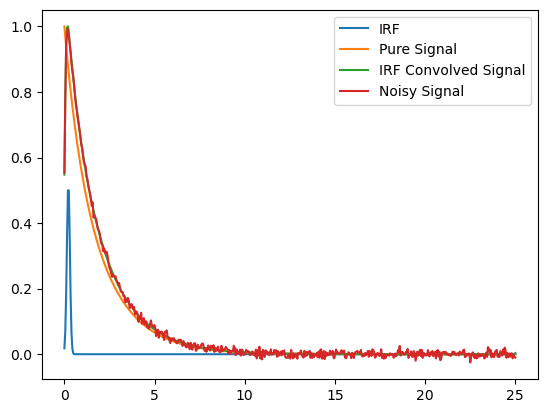

In [1464]:
##Simulate data test
N=512
irf, t = gaussian_irf(40,N,0.2)
#iirf = irf
sig, t, avg_it = gen_signal(40, N, (0.2,0.8), (0.8,2)) # generate two component decay 
sig_irf, t,avg_t = gen_signal(40, N, (0.2, 0.8), (0.8, 2), irf) # generate decay with irf
sig_noisy = add_white_noise(sig_irf, 20) # add white noise at 20 db

#shift and scale irf for nice display:
nonZeroIdx = np.argmin(np.abs(irf[:int(len(irf)/2)] - 1/20))
irf = 0.5 * np.roll(irf, -nonZeroIdx)

plt.plot(t * 10**9, irf, label="IRF")
plt.plot(t * 10**9, sig, label="Pure Signal")
plt.plot(t * 10**9, sig_irf, label = "IRF Convolved Signal")
plt.plot(t * 10**9, sig_noisy, label = "Noisy Signal")
plt.legend()
plt.show()

In [2311]:
#Get C, V, D, 
#cost function is ||C{V.T@y-D.T@lambda}||^2
#N=t*10**9
N=512
alpha = 0.82
L = 12
#alpha = 0.885
#L=8
#alpha=0.93
#L=4
iirf=irf #use this for centered version
#V = compute_V(len(N), alpha, L, iirf)
V = compute_V(N, alpha, L, iirf)
V_V_T_inv = np.linalg.inv(V.T@V)
C = compute_cholesky(V_V_T_inv)
#FFD3 = Compute_ForwardFiniteDiff(L,len(N),alpha)
FFD3 = Compute_ForwardFiniteDiff(L,N,alpha)
print("Done Computing")

Done Computing


In [2313]:
#Perform the minimization with built in optimizer
lmbda = np.zeros(len(FFD3))
lmbda_min = CLSD_minimize(lmbda,C,V,sig_irf, FFD3)

# Output results
if lmbda_min.success:
    #print("Optimal lambda:", lmbda_min.x)
    print(lmbda_min.x.shape)
    print("Minimum objective function value:", lmbda_min.fun)
else:
    print("Optimization failed:", lmbda_min.message)

(509,)
Minimum objective function value: 2253.6227596645276


In [2315]:
#Find coefficents based off optimized lambda
C_cls=compute_Ccls(V,C,FFD3,lmbda_min,sig_irf) #constrained least squares coefficients'
print("Got coefficients")

Got coefficients


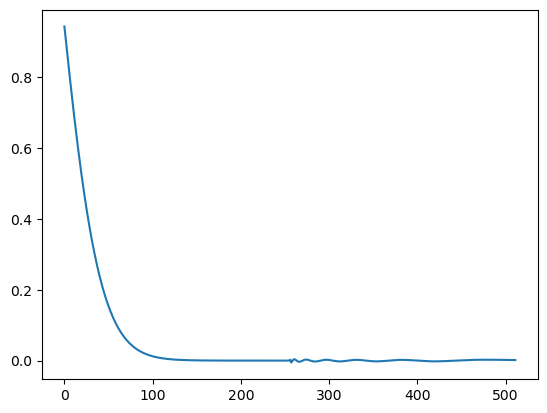

In [2317]:
#compute the fIRF
#h_fIRF = ComputefIRF(C_cls, len(N), alpha, L)
h_fIRF = ComputefIRF(C_cls, N, alpha, L)

#convolve with the irf function
output_response = np.convolve(iirf, h_fIRF, mode = 'same')
plt.plot(np.arange(N),output_response, label = "Output Response")
#plt.savefig('cls.png')
plt.show()

In [2319]:
# set seed for reproducibility
np.random.seed(100)

# iIRF parameters
rep_rate = 40
k = 512
fwhm = 0.2

# iIRF only needs to be generated once
# it is measured one time and the sa
# me for all signals
iirf, t = gaussian_irf(rep_rate, k, fwhm)

nonZeroIdx = np.argmin(np.abs(iirf[:int(len(iirf)/2)] - 1/20))
iirf_aligned = 0.5 * np.roll(iirf, -nonZeroIdx)

# number of sets to generate
N = 1000

In [2321]:
# fractional contributions and taus randomly generated
# in this case, based on the information in the paper,
# fractional contributions are generated from a uniform distribution between 
# 0 and 100%
# and taus are randomly generated from a uniform distribution between 1 and 6 ns
# and the number of exponential components generated is randomly picked from 1-6
rng = np.random.default_rng(100)
M = rng.integers(low=1, high=6, size=N)
# TODO order fracs and taus correctly for input into gen_signal
parts = [rng.random(m) for m in M]
fracs = [parts[n] / sum(parts[n]) for n in range(N)]
taus = [rng.uniform(low = 1, high = 6, size = m) for m in M]

In [2323]:
decays = []
avg_taus = []
for n in range(N):
    decay, t, avg_lts = gen_signal(rep_rate, k, fracs[n], taus[n], iirf)
    noisy_decay = add_white_noise(decay, 20)
    decays.append(noisy_decay)
    avg_taus.append(avg_lts)

In [2325]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2327]:
alpha = 0.829
L = 12
dt = t[1]
B = basis_array(k, alpha, L)
V = compute_V(k, alpha, L, iirf)
regr = linear_model.LinearRegression()
reg_pred = []
reg_coefs = []
reg_pred_taus = []
inv_pred = []
inv_coefs = []
inv_pred_taus = []
for i in decays:
    regr.fit(V, i)
    reg_pred.append(regr.predict(V))
    reg_coefs.append(regr.coef_)
    reg_pred_taus.append(compute_tau_avg(regr.coef_, dt, B, k) * 1e9)
    chat = np.linalg.inv(np.transpose(V) @ V) @ np.transpose(V) @ i
    inv_coefs.append(chat)
    inv_pred.append( V @ chat)
    inv_pred_taus.append(compute_tau_avg(chat, dt, B, k) * 1e9)

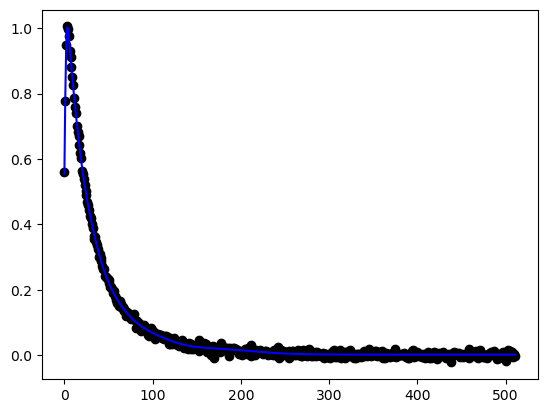

In [2328]:
i = k
plt.plot(np.arange(k), reg_pred[i], color = 'blue')
plt.scatter(np.arange(k), decays[i], color = 'black')

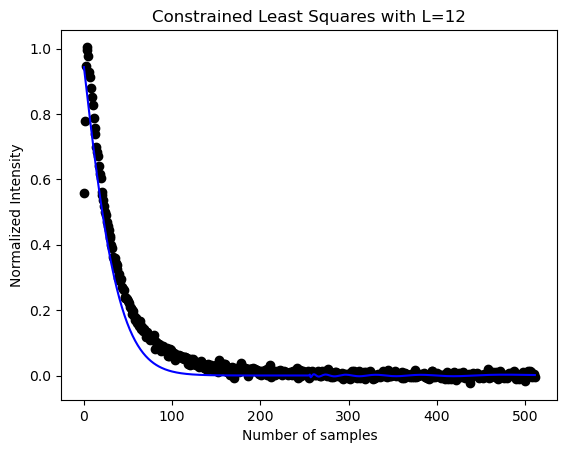

In [2329]:
plt.plot(np.arange(k), output_response, color = 'blue')
plt.scatter(np.arange(k), decays[i], color = 'black')
plt.title("Constrained Least Squares with L=12")
plt.xlabel("Number of samples")
plt.ylabel("Normalized Intensity")
plt.savefig('Constrained Least Squares with L=12 and alpha=0.82.png')
#plt.savefig('Constrained Least Squares with L=4 and alpha=0.925.png')

In [2333]:
mse = np.sum((decays[i]-output_response)**2)
print(mse)

0.833923239109696


0.9397145308052315
